1. テーマ
ソウルのPM10とPM2.5を予測するマシンラーニング

2. 企画、目標
ソウルはPM10とPM2.5で悩まされ、外出するすると必ずマスクをつけるようになりました。韓国の国内で発生したものだとしたら、四季によることは少ないことが当然ですが、冬と春はひどく濃いPM2.5で、中国を疑っています。

それで、私たちは北京とソウルの空気のデータを使い、ソウルの一年間のPM10とPM2.5の予報が出来るようにするとともにどのくらい中国からの影響があるのか試してみようとしております。


# Package Import 

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Data Preprocessing

## (Korea) String Date To Unix Time Stamp

In [ ]:
from datetime import datetime
import time

def make_date_list(np_list, col):
  return_list = []
  epoch_time = datetime(1970, 1, 1)
  date_format = '%Y-%m-%d:%H'
  

  for row in np_list[col]:
    tmp = row.split(':')
    added_time = 0

    if tmp[1] == '24':
      row = tmp[0]+":00"
      added_time = 86400
    

    return_list.append(
        (datetime.strptime(row, date_format) - epoch_time).total_seconds() + added_time
    )
  
  return return_list


seoul_2015_df = pd.read_excel('2015_Air_Quality_Seoul.xls')
seoul_2016_df = pd.read_excel('2016_Air_Quality_Seoul.xls')
baek_2015_df = pd.read_excel('baek_2015.xls')
baek_2016_df = pd.read_excel('baek_2016.xls')

date_2015_list = make_date_list(seoul_2015_df, '날짜')
date_2016_list = make_date_list(seoul_2016_df, '날짜')
date_baek_2015_list = make_date_list(baek_2015_df, '날짜')
date_baek_2016_list = make_date_list(baek_2016_df, '날짜')

sr1 = pd.Series(date_2015_list, name='unix_time')
sr2 = pd.Series(date_2016_list, name='unix_time')
sr3 = pd.Series(date_baek_2015_list, name='unix_time')
sr4 = pd.Series(date_baek_2016_list, name='unix_time')

seoul_2015_df = seoul_2015_df.drop('날짜', axis=1)
seoul_2016_df = seoul_2016_df.drop('날짜', axis=1)
baek_2015_df = baek_2015_df.drop('날짜', axis=1)
baek_2016_df = baek_2016_df.drop('날짜', axis=1)

seoul_2015_df = pd.concat([sr1, seoul_2015_df], axis=1)
seoul_2016_df = pd.concat([sr2, seoul_2016_df], axis=1)
baek_2015_df = pd.concat([sr3, baek_2015_df], axis=1)
baek_2016_df = pd.concat([sr4, baek_2016_df], axis=1)

seoul_15_16_df = pd.concat([seoul_2015_df, seoul_2015_df], axis=0)
baek_15_16_df = pd.concat([baek_2015_df, baek_2016_df], axis=0)

In [ ]:
seoul_15_16_df

,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Ozone,NO2,NO,SO2,Wind speed,Wind direction
0,1.420074e+09,44.0,7.0,0.022,0.011,0.6,0.006,4.7,WNW
1,1.420078e+09,57.0,10.0,0.022,0.010,0.6,0.006,4.5,WNW
2,1.420081e+09,76.0,10.0,0.021,0.010,0.6,0.006,3.8,WNW
3,1.420085e+09,86.0,11.0,0.022,0.009,0.6,0.006,4.9,WNW
4,1.420088e+09,106.0,12.0,0.021,0.009,0.5,0.006,5.7,WNW
...,...,...,...,...,...,...,...,...,...
8755,1.451592e+09,88.0,51.0,0.003,0.075,1.0,0.009,0.8,NE
8756,1.451596e+09,84.0,49.0,0.003,0.080,1.2,0.009,1.2,NE
8757,1.451599e+09,97.0,52.0,0.003,0.076,1.1,0.008,1.1,NE
8758,1.451603e+09,93.0,48.0,0.002,0.078,1.1,0.008,0.8,NE


In [ ]:
baek_15_16_df

,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Ozone,NO2,NO,SO2,Wind speed,Wind direction
0,1.420074e+09,106.0,9.0,0.029,0.002,0.2,0.003,8.4,WNW
1,1.420078e+09,114.0,11.0,0.029,0.002,0.2,0.003,8.7,WNW
2,1.420081e+09,113.0,12.0,0.028,0.003,0.2,0.003,9.1,WNW
3,1.420085e+09,120.0,13.0,0.027,0.003,0.2,0.003,7.9,WNW
4,1.420088e+09,96.0,17.0,0.027,0.003,0.2,0.003,6.8,WNW
...,...,...,...,...,...,...,...,...,...
8773,1.483211e+09,76.0,48.0,0.051,0.002,0.6,0.005,1.9,WSW
8774,1.483214e+09,79.0,54.0,0.050,0.002,0.6,0.006,1.6,WSW
8775,1.483218e+09,86.0,56.0,0.050,0.002,0.6,0.006,2.4,WSW
8776,1.483222e+09,87.0,57.0,0.047,0.002,0.5,0.007,3.0,WSW


## (Korea) Drop some of useless columns and remove null values

In [ ]:
seoul_15_16_df = seoul_15_16_df.drop(['Ozone', 'NO2', 'NO', 'SO2',], axis=1).dropna()
seoul_15_16_df

,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Wind speed,Wind direction
0,1.420074e+09,44.0,7.0,4.7,WNW
1,1.420078e+09,57.0,10.0,4.5,WNW
2,1.420081e+09,76.0,10.0,3.8,WNW
3,1.420085e+09,86.0,11.0,4.9,WNW
4,1.420088e+09,106.0,12.0,5.7,WNW
...,...,...,...,...,...
8755,1.451592e+09,88.0,51.0,0.8,NE
8756,1.451596e+09,84.0,49.0,1.2,NE
8757,1.451599e+09,97.0,52.0,1.1,NE
8758,1.451603e+09,93.0,48.0,0.8,NE


In [ ]:
baek_15_16_df = baek_15_16_df.drop(['Ozone', 'NO2', 'NO', 'SO2',], axis=1).dropna()
baek_15_16_df

,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Wind speed,Wind direction
0,1.420074e+09,106.0,9.0,8.4,WNW
1,1.420078e+09,114.0,11.0,8.7,WNW
2,1.420081e+09,113.0,12.0,9.1,WNW
3,1.420085e+09,120.0,13.0,7.9,WNW
4,1.420088e+09,96.0,17.0,6.8,WNW
...,...,...,...,...,...
8773,1.483211e+09,76.0,48.0,1.9,WSW
8774,1.483214e+09,79.0,54.0,1.6,WSW
8775,1.483218e+09,86.0,56.0,2.4,WSW
8776,1.483222e+09,87.0,57.0,3.0,WSW


## (Korea) Categorize wind direction

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
wd_seoul = encoder.fit_transform(seoul_15_16_df['Wind direction'])
wd_baek = encoder.fit_transform(baek_15_16_df['Wind direction'])
wd_seoul = pd.Series(wd_seoul.tolist(), name='Wind direction')
wd_baek = pd.Series(wd_baek.tolist(), name='Wind direction')
seoul_15_16_df = seoul_15_16_df.reset_index()
baek_15_16_df = baek_15_16_df.reset_index()

seoul_15_16_df = seoul_15_16_df.drop('Wind direction', axis=1)
baek_15_16_df = baek_15_16_df.drop('Wind direction', axis=1)
seoul_15_16_df = pd.concat([seoul_15_16_df, wd_seoul], axis=1)
baek_15_16_df = pd.concat([baek_15_16_df, wd_baek], axis=1)

seoul_15_16_df = seoul_15_16_df.drop('index', axis=1)
seoul_15_16_df.columns = ['unix_time', 'PM10_seoul', 'PM2.5_seoul', 'WS_seoul', 'WD_seoul']
seoul_15_16_df

,unix_time,PM10_seoul,PM2.5_seoul,WS_seoul,WD_seoul
0,1.420074e+09,44.0,7.0,4.7,14
1,1.420078e+09,57.0,10.0,4.5,14
2,1.420081e+09,76.0,10.0,3.8,14
3,1.420085e+09,86.0,11.0,4.9,14
4,1.420088e+09,106.0,12.0,5.7,14
...,...,...,...,...,...
16961,1.451592e+09,88.0,51.0,0.8,4
16962,1.451596e+09,84.0,49.0,1.2,4
16963,1.451599e+09,97.0,52.0,1.1,4
16964,1.451603e+09,93.0,48.0,0.8,4


In [ ]:
baek_15_16_df = baek_15_16_df.drop('index', axis=1)
baek_15_16_df.columns = ['unix_time', 'PM10_baek', 'PM2.5_baek', 'WS_baek', 'WD_baek']
baek_15_16_df

,unix_time,PM10_baek,PM2.5_baek,WS_baek,WD_baek
0,1.420074e+09,106.0,9.0,8.4,14
1,1.420078e+09,114.0,11.0,8.7,14
2,1.420081e+09,113.0,12.0,9.1,14
3,1.420085e+09,120.0,13.0,7.9,14
4,1.420088e+09,96.0,17.0,6.8,14
...,...,...,...,...,...
15838,1.483211e+09,76.0,48.0,1.9,15
15839,1.483214e+09,79.0,54.0,1.6,15
15840,1.483218e+09,86.0,56.0,2.4,15
15841,1.483222e+09,87.0,57.0,3.0,15


## (Beijing) String Date to Unix Stamp 

In [ ]:
china_df = pd.read_csv('2015-2017 PRSA_Data_Aotizhongxin.csv')
china_strdate_df = china_df.loc[:, 'year':'hour'].astype('str')
china_sr = china_strdate_df['year'] + '-' + china_strdate_df['month'] + '-' + china_strdate_df['day'] + ':' + china_strdate_df['hour']
china_sr = china_sr.rename('날짜')

china_df = china_df.drop(['No', 'year', 'month', 'day', 'hour'], axis=1)
china_df = pd.concat([china_sr, china_df], axis=1)

china_time_stamp_list = date_2015_list = make_date_list(china_df, '날짜')
china_sr = pd.Series(china_time_stamp_list, name='unix_time')
china_df = china_df.drop('날짜', axis=1)
china_df = pd.concat([china_sr, china_df], axis=1)
china_df

,unix_time,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1.420070e+09,13.0,50.0,19.0,29.0,500.0,28.0,-1.0,1027.0,-22.4,0.0,NNW,4.4,Aotizhongxin
1,1.420074e+09,11.0,30.0,15.0,31.0,600.0,27.0,-1.0,1027.0,-23.7,0.0,N,5.6,Aotizhongxin
2,1.420078e+09,13.0,33.0,16.0,32.0,600.0,26.0,-1.0,1028.0,-23.7,0.0,N,4.2,Aotizhongxin
3,1.420081e+09,10.0,29.0,10.0,25.0,500.0,31.0,-1.0,1029.0,-24.4,0.0,N,4.4,Aotizhongxin
4,1.420085e+09,12.0,25.0,14.0,33.0,700.0,24.0,-2.0,1027.0,-23.2,0.0,ENE,1.4,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18955,1.488308e+09,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
18956,1.488312e+09,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
18957,1.488316e+09,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
18958,1.488319e+09,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin


## (Beijing) Drop some of useless columns

In [ ]:
china_df = china_df.drop(['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'station'], axis=1)
china_df

,unix_time,PM2.5,PM10,wd,WSPM
0,1.420070e+09,13.0,50.0,NNW,4.4
1,1.420074e+09,11.0,30.0,N,5.6
2,1.420078e+09,13.0,33.0,N,4.2
3,1.420081e+09,10.0,29.0,N,4.4
4,1.420085e+09,12.0,25.0,ENE,1.4
...,...,...,...,...,...
18955,1.488308e+09,12.0,29.0,NW,2.4
18956,1.488312e+09,13.0,37.0,WNW,0.9
18957,1.488316e+09,16.0,37.0,NW,1.1
18958,1.488319e+09,21.0,44.0,NNW,1.2


## (Beijing) Remove Null Values

In [ ]:
china_df.isnull().sum()

unix_time      0
PM2.5        409
PM10         226
wd            78
WSPM          14
dtype: int64

In [ ]:
china_df = china_df.dropna()
china_df.reset_index()
china_df.isnull().sum()

unix_time    0
PM2.5        0
PM10         0
wd           0
WSPM         0
dtype: int64

## (Beijing) Categorize wind direction

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
wd_beijing = encoder.fit_transform(china_df['wd'])
wd_beijing = pd.Series(wd_beijing.tolist(), name='wd')
china_df = china_df.reset_index()

china_df = china_df.drop('wd', axis=1)
china_df = pd.concat([china_df, wd_beijing], axis=1)
china_df

,index,unix_time,PM2.5,PM10,WSPM,wd
0,0,1.420070e+09,13.0,50.0,4.4,6
1,1,1.420074e+09,11.0,30.0,5.6,3
2,2,1.420078e+09,13.0,33.0,4.2,3
3,3,1.420081e+09,10.0,29.0,4.4,3
4,4,1.420085e+09,12.0,25.0,1.4,1
...,...,...,...,...,...,...
18464,18955,1.488308e+09,12.0,29.0,2.4,7
18465,18956,1.488312e+09,13.0,37.0,0.9,14
18466,18957,1.488316e+09,16.0,37.0,1.1,7
18467,18958,1.488319e+09,21.0,44.0,1.2,6


## Date alignment

In [ ]:
china_df_copy = china_df.copy()
china_df_copy['unix_time'] = china_df_copy['unix_time']+86400
seoul_15_16_df['unix_time'] = seoul_15_16_df['unix_time']


china_df_copy = china_df_copy.drop('index', axis=1)
china_df_copy.columns = ['unix_time', 'PM2.5_ch', 'PM10_ch', 'WSPM_ch', 'wd_ch']
china_df_copy

,unix_time,PM2.5_ch,PM10_ch,WSPM_ch,wd_ch
0,1.420157e+09,13.0,50.0,4.4,6
1,1.420160e+09,11.0,30.0,5.6,3
2,1.420164e+09,13.0,33.0,4.2,3
3,1.420168e+09,10.0,29.0,4.4,3
4,1.420171e+09,12.0,25.0,1.4,1
...,...,...,...,...,...
18464,1.488395e+09,12.0,29.0,2.4,7
18465,1.488398e+09,13.0,37.0,0.9,14
18466,1.488402e+09,16.0,37.0,1.1,7
18467,1.488406e+09,21.0,44.0,1.2,6


## Merge dataframes

In [ ]:
df = pd.merge(seoul_15_16_df, china_df_copy, on='unix_time')
df = pd.merge(df, baek_15_16_df, on='unix_time')
df

,unix_time,PM10_seoul,PM2.5_seoul,WS_seoul,WD_seoul,PM2.5_ch,PM10_ch,WSPM_ch,wd_ch,PM10_baek,PM2.5_baek,WS_baek,WD_baek
0,1.420157e+09,21.0,9.0,2.4,13,13.0,50.0,4.4,6,16.0,6.0,7.0,14
1,1.420157e+09,21.0,9.0,2.4,13,13.0,50.0,4.4,6,16.0,6.0,7.0,14
2,1.420160e+09,25.0,9.0,1.1,6,11.0,30.0,5.6,3,16.0,6.0,8.4,14
3,1.420160e+09,25.0,9.0,1.1,6,11.0,30.0,5.6,3,16.0,6.0,8.4,14
4,1.420164e+09,24.0,9.0,1.8,13,13.0,33.0,4.2,3,13.0,4.0,9.1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14717,1.451596e+09,84.0,49.0,1.2,4,14.0,14.0,2.2,1,35.0,25.0,3.8,14
14718,1.451599e+09,97.0,52.0,1.1,4,17.0,17.0,1.3,4,27.0,21.0,3.7,14
14719,1.451599e+09,97.0,52.0,1.1,4,17.0,17.0,1.3,4,27.0,21.0,3.7,14
14720,1.451603e+09,93.0,48.0,0.8,4,22.0,22.0,1.5,3,33.0,18.0,3.4,13


## remove anomaly data(삭제 할 것 같음)

In [ ]:
# df.loc[:, 'PM10_baek':].boxplot()

In [ ]:
# def outliers_iqr(data):
#   q1, q3 = np.percentile(data, [25,75])
#   iqr = q3 - q1
#   lower_bound = q1 - (iqr * 1.5)
#   upper_bound = q3 + (iqr * 1.5)

#   return np.where((data > upper_bound) | (data < lower_bound))

# pm10_index = outliers_iqr(df['PM10(㎍/㎥)'])[0]
# df = df.drop(pm10_index, axis=0)
# df = df.reset_index().drop('index', axis=1)

# pm25_index = outliers_iqr(df['PM2.5(㎍/㎥)'])[0]
# df.loc[pm25_index, 'PM2.5(㎍/㎥)']
# df = df.drop(pm25_index, axis=0)
# df = df.reset_index().drop('index', axis=1)

# pm10_index_ch = outliers_iqr(df['PM10_ch'])[0]
# df.loc[pm10_index_ch, 'PM10_ch']
# df = df.drop(pm10_index_ch, axis=0)
# df = df.reset_index().drop('index', axis=1)

# pm25_index_ch = outliers_iqr(df['PM2.5_ch'])[0]
# df.loc[pm25_index_ch, 'PM2.5_ch']
# df = df.drop(pm25_index_ch, axis=0)
# df = df.reset_index().drop('index', axis=1)

In [ ]:
# df.loc[:, 'PM10(㎍/㎥)':].boxplot()

In [ ]:
df.isnull().sum()

unix_time      0
PM10_seoul     0
PM2.5_seoul    0
WS_seoul       0
WD_seoul       0
PM2.5_ch       0
PM10_ch        0
WSPM_ch        0
wd_ch          0
PM10_baek      0
PM2.5_baek     0
WS_baek        0
WD_baek        0
dtype: int64

# Model - 1 (PM10)

## Time Scailing & PM10 PM2.5 log scaling

In [ ]:
time_sr = df['unix_time'] / 10**9
time_sr = time_sr.rename('unix_time')
pm10_sr_seoul = df['PM10_seoul']
pm10_sr_seoul = np.log10(pm10_sr_seoul)
pm10_sr_seoul = pm10_sr_seoul.rename('PM10_seoul')
pm25_sr_seoul = df['PM2.5_seoul']
pm25_sr_seoul = np.log10(pm25_sr_seoul)
pm25_sr_seoul = pm25_sr_seoul.rename('PM2.5_seoul')

In [ ]:
# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
title = ['unix_time',	'PM10_seoul', 'PM2.5_seoul', 'WS_seoul', 'WD_seoul', 'PM2.5_ch', 'PM10_ch', 'WSPM_ch', 'wd_ch','PM10_baek', 'PM2.5_baek', 'WS_baek', 'WD_baek',]
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=title)

scaled_df['unix_time'] = time_sr
scaled_df['PM10_seoul'] = pm10_sr_seoul
scaled_df['PM2.5_seoul'] = pm25_sr_seoul

scaled_df

,unix_time,PM10_seoul,PM2.5_seoul,WS_seoul,WD_seoul,PM2.5_ch,PM10_ch,WSPM_ch,wd_ch,PM10_baek,PM2.5_baek,WS_baek,WD_baek
0,1.420157,1.322219,0.954243,-0.145251,0.876002,-0.802185,-0.624833,1.992917,-0.054308,-0.571922,-0.840608,1.280499,1.107285
1,1.420157,1.322219,0.954243,-0.145251,0.876002,-0.802185,-0.624833,1.992917,-0.054308,-0.571922,-0.840608,1.280499,1.107285
2,1.420160,1.397940,0.954243,-1.054190,-0.442967,-0.824897,-0.819004,2.944430,-0.673128,-0.571922,-0.840608,1.884139,1.107285
3,1.420160,1.397940,0.954243,-1.054190,-0.442967,-0.824897,-0.819004,2.944430,-0.673128,-0.571922,-0.840608,1.884139,1.107285
4,1.420164,1.380211,0.954243,-0.564761,0.876002,-0.802185,-0.789879,1.834332,-0.673128,-0.628442,-0.932229,2.185959,1.107285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14717,1.451596,1.924279,1.690196,-0.984272,-0.819816,-0.790829,-0.974341,0.248478,-1.085674,-0.213966,0.029791,-0.099250,1.107285
14718,1.451599,1.986772,1.716003,-1.054190,-0.819816,-0.756761,-0.945215,-0.465157,-0.466854,-0.364685,-0.153450,-0.142367,1.107285
14719,1.451599,1.986772,1.716003,-1.054190,-0.819816,-0.756761,-0.945215,-0.465157,-0.466854,-0.364685,-0.153450,-0.142367,1.107285
14720,1.451603,1.968483,1.681241,-1.263945,-0.819816,-0.699981,-0.896673,-0.306571,-0.673128,-0.251646,-0.290882,-0.271718,0.908292


## Data split

In [ ]:
x = scaled_df.loc[:, 'WS_seoul':]
x['unix_time'] = scaled_df['unix_time']
y_pm10 = scaled_df['PM10_seoul']
y_pm25 = scaled_df['PM2.5_seoul']
y_pm10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0        1.322219
1        1.322219
2        1.397940
3        1.397940
4        1.380211
           ...   
14717    1.924279
14718    1.986772
14719    1.986772
14720    1.968483
14721    1.968483
Name: PM10_seoul, Length: 14722, dtype: float64

In [ ]:
# 데이터 분할하기
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y_pm10, test_size=0.30, random_state=5)
print('x_train: ', x_train.shape)
print('x_test:', x_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

x_train:  (10305, 11)
x_test: (4417, 11)
y_train:  (10305,)
y_test:  (4417,)


## Model Learning

In [ ]:
BATCH_SIZE = 16
EPOCH_SIZE = 32

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(units=300, activation='relu', input_dim=11))
model.add(Dense(units=250, activation='relu'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=150, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 300)               3600      
_________________________________________________________________
dense_15 (Dense)             (None, 250)               75250     
_________________________________________________________________
dense_16 (Dense)             (None, 200)               50200     
_________________________________________________________________
dense_17 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_19 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train, y_train, verbose=1, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Epoch 1/32
645/645 [==============================] - 4s 5ms/step - loss: 0.0123 - accuracy: 0.0104 - val_loss: 0.0257 - val_accuracy: 0.0086
Epoch 2/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0123 - accuracy: 0.0082 - val_loss: 0.0235 - val_accuracy: 0.0086
Epoch 3/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0113 - accuracy: 0.0099 - val_loss: 0.0237 - val_accuracy: 0.0086
Epoch 4/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0103 - accuracy: 0.0080 - val_loss: 0.0227 - val_accuracy: 0.0086
Epoch 5/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0088 - accuracy: 0.0091 - val_loss: 0.0227 - val_accuracy: 0.0086
Epoch 6/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0090 - accuracy: 0.0077 - val_loss: 0.0232 - val_accuracy: 0.0086
Epoch 7/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0102 - accuracy: 0.0103 - val_loss: 0.0229 - val_accuracy: 0.0086
Epoch 

# Predict - 1 (PM10)

In [ ]:
# 예측, y값을 주면 안된다.
pred = model.predict(x_test)
print(pred.shape, y_test.shape, x_test['unix_time'].shape)
pred

(4417, 1) (4417,) (4417,)


array([[1.7369074],
       [1.1704764],
       [1.7076931],
       ...,
       [1.2012159],
       [1.4821568],
       [0.720883 ]], dtype=float32)

## Scatter plot (Corrects vs Predictions)

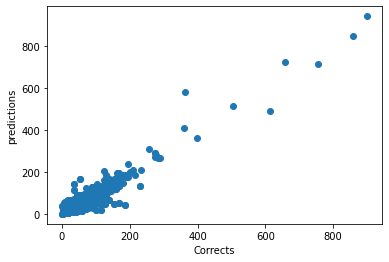

In [ ]:
plt.scatter(10**y_test, 10**pred)
plt.xlabel('Corrects')
plt.ylabel('predictions')
plt.show()

## Time evolution plots

In [ ]:
time_tst_sr = x_test['unix_time']
pred = pd.Series(pred.reshape(4417,), name='predictions')
df_label = pd.concat([time_tst_sr, y_test], axis=1)
time_tsr_sr2 = time_tst_sr.reset_index()
df_pred = pd.concat([time_tsr_sr2, pred], axis=1)
df_label = df_label.sort_values(by=['unix_time'])
df_pred = df_pred.sort_values(by=['unix_time'])
df_pred

,index,unix_time,predictions
4052,1,1.420157,1.579077
4277,0,1.420157,1.579077
2207,6,1.420168,1.412757
111,8,1.420171,1.342177
981,15,1.420182,1.465995
...,...,...,...
395,14711,1.451585,1.848144
3992,14712,1.451588,1.766262
2865,14713,1.451588,1.766262
3560,14718,1.451599,1.928088


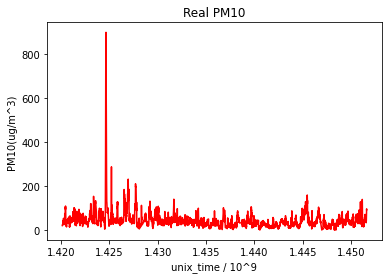

In [ ]:
plt.plot(df_label['unix_time'], 10**df_label['PM10_seoul'], color='red')
plt.xlabel('unix_time / 10^9')
plt.ylabel('PM10(ug/m^3)')
plt.title('Real PM10')
plt.show()

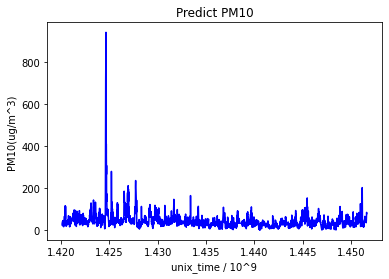

In [ ]:
plt.plot(df_pred['unix_time'], 10**df_pred['predictions'], color='blue')
plt.xlabel('unix_time / 10^9')
plt.ylabel('PM10(ug/m^3)')
plt.title('Predict PM10')
plt.show()

# Model - 2 (PM2.5)

## Data split

In [ ]:
# 데이터 분할하기
from sklearn.model_selection import train_test_split

x_train, x_test, y_train_2, y_test_2 = train_test_split(x, y_pm25, test_size=0.30, random_state=5)
print('x_train: ', x_train.shape)
print('x_test:', x_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

x_train:  (10305, 11)
x_test: (4417, 11)
y_train:  (10305,)
y_test:  (4417,)


## Model Learning

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
model2 = Sequential()
model2.add(Dense(units=300, activation='relu', input_dim=11)) # 12개가 들어와 300개로 나뉜다
model2.add(Dense(units=250, activation='relu')) # 250개가 들어와
model2.add(Dense(units=200, activation='relu')) # 200개가 들어와
model2.add(Dense(units=150, activation='relu')) # 150개가 들어와
model2.add(Dense(units=100, activation='relu')) # 100개가 들어와
model2.add(Dense(units=50, activation='relu')) # 50개가 들어와
model2.add(Dense(units=1, activation='linear')) # 마지막 출구로 1개에 리니어

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 300)               3600      
_________________________________________________________________
dense_22 (Dense)             (None, 250)               75250     
_________________________________________________________________
dense_23 (Dense)             (None, 200)               50200     
_________________________________________________________________
dense_24 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_26 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                

In [ ]:
model2.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])
model2.fit(x_train, y_train_2, verbose=1, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_data=(x_test, y_test_2))

Epoch 1/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0088 - accuracy: 0.0268 - val_loss: 0.0249 - val_accuracy: 0.0294
Epoch 2/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0071 - accuracy: 0.0313 - val_loss: 0.0243 - val_accuracy: 0.0292
Epoch 3/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0061 - accuracy: 0.0287 - val_loss: 0.0239 - val_accuracy: 0.0292
Epoch 4/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0056 - accuracy: 0.0295 - val_loss: 0.0236 - val_accuracy: 0.0292
Epoch 5/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0054 - accuracy: 0.0305 - val_loss: 0.0234 - val_accuracy: 0.0292
Epoch 6/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0054 - accuracy: 0.0303 - val_loss: 0.0232 - val_accuracy: 0.0292
Epoch 7/32
645/645 [==============================] - 3s 4ms/step - loss: 0.0050 - accuracy: 0.0303 - val_loss: 0.0231 - val_accuracy: 0.0292
Epoch 

# Predict - 2 (PM2.5)

In [ ]:
# 예측, y값을 주면 안된다.
pred_2 = model2.predict(x_test)
print(pred.shape, y_test_2.shape, x_test['unix_time'].shape)
pred_2

(4417, 1) (4417,) (4417,)


array([[1.5097743 ],
       [1.0915313 ],
       [1.2920464 ],
       ...,
       [0.96170604],
       [1.2649105 ],
       [0.39704037]], dtype=float32)

## Scatter plot (Corrects vs Predictions)

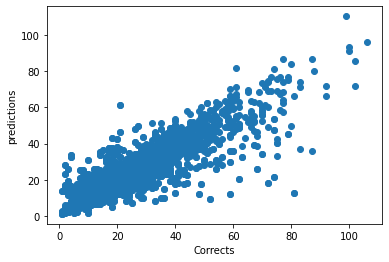

In [ ]:
plt.scatter(10**y_test_2, 10**pred_2)
plt.xlabel('Corrects')
plt.ylabel('predictions')
plt.show()

## Time evolution plots

In [ ]:
time_tst_sr = x_test['unix_time']
pred_2 = pd.Series(pred_2.reshape(4417,), name='predictions')
df_label = pd.concat([time_tst_sr, y_test_2], axis=1)
time_tsr_sr2 = time_tst_sr.reset_index()
df_pred = pd.concat([time_tsr_sr2, pred_2], axis=1)
df_label = df_label.sort_values(by=['unix_time'])
df_pred = df_pred.sort_values(by=['unix_time'])
df_pred

,index,unix_time,predictions
4052,1,1.420157,1.021284
4277,0,1.420157,1.021284
2207,6,1.420168,0.972533
111,8,1.420171,0.892462
981,15,1.420182,1.206077
...,...,...,...
395,14711,1.451585,1.650321
3992,14712,1.451588,1.441912
2865,14713,1.451588,1.441912
3560,14718,1.451599,1.690596


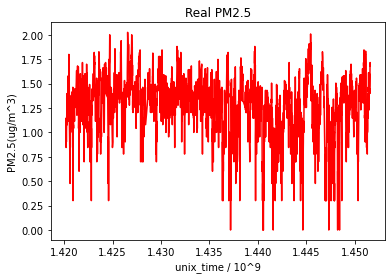

In [ ]:
plt.plot(df_label['unix_time'], df_label['PM2.5_seoul'], color='red')
plt.xlabel('unix_time / 10^9')
plt.ylabel('PM2.5(ug/m^3)')
plt.title('Real PM2.5')
plt.show()

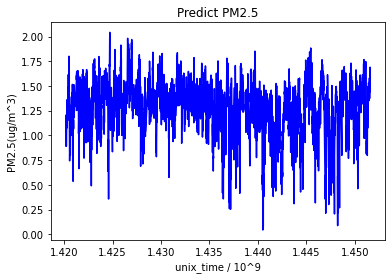

In [ ]:
plt.plot(df_pred['unix_time'], df_pred['predictions'], color='blue')
plt.xlabel('unix_time / 10^9')
plt.ylabel('PM2.5(ug/m^3)')
plt.title('Predict PM2.5')
plt.show()

# Result & Discussion

日本語:  
  
大韓民国のPM10とPM2.5は、中国で発生したものの影響を受けると推測され、上のようなソウルの空気質を予測する機械学習プロジェクトを実施しました。  
  
初期には北京の空気質、風向、風速のデータとソウルの空気質、風向、風速のデータのみを利用して予測を行いました。 この時北京から韓国まで空気の対流が到達する時間を考慮し、北京のデータは前日のデータと結合して学習を行いました。  
  
その結果、北京とソウルだけのデータで学習させた場合、予測の正確度が落ちる傾向を示しました。 これにより、中国の空気質に大きな影響を受けるペクリョン島の空気質、風向、風速のデータを追加することを決め、3つの地域のデータセットを利用して学習させた結果、予測の数値と実測の数値の差はありましたが、グラフの傾向は一致しました。
  
PM2.5の移動は対流現象と密接に関連しているため、機械学習だけでは中国の影響が大きいという結論を導き出す直接的な根拠にはなりませんが、一つの補助根拠として使われるものと判断され、中国のPM2.5程度によっては、韓国のPM2.5警報の発令を事前に実施できるものと判断されます。  
  
現在のプロジェクトの後の課題としては中国の協力をもらい、北京より大きな影響を与えると疑上海などの空気質、風向、風速のデータを提供してもらって、また、モデリングすることで機械学習の正確度を高めていくことが出来ると判断されております。

한국어:  
  
대한민국의 미세먼지는 중국에서 만들어진 미세먼지에 영향을 받는다고 추측되어 위와 같은 서울의 공기질 예측 기계학습 프로젝트를 실시하였다.  
  
초기에는 베이징의 공기질, 풍향, 풍속 데이터와 서울의 공기질, 풍향, 풍속 데이터만을 이용하여 예측을 실시하였다. 이 때 베이징으로부터 대한민국까지 공기의 흐름이 도달하는 시간을 고려하여 베이징의 데이터는 하루 전 데이터와 결합하여 학습을 실시하였다.  
  
그 결과 베이징과 서울만의 데이터로 학습시킨 경우 예측도가 떨어지는 경향을 보였다. 이에 따라 중국의 공기질에 큰 영향을 받는 백령도의 공기질, 풍향, 풍속 데이터를 추가하기로 결정하였고 세 지역의 데이터셋을 이용하여 학습시킨 결과 예측과 실측의 값 자체는 차이를 보였으나 경향성이 일치하는 결과를 보여주었다.  
  
미세먼지의 이동은 대류현상과 밀접한 연관이 있기에, 기계학습 만으로는 중국의 영향이 지대하다는 결론을 도출할 직접적인 근거가 될 수는 없으나 하나의 보조근거로서 쓰일 수 있을 것으로 판단되고 중국의 미세먼지 정도에 따라 대한민국의 미세먼지경보 발령을 사전에 실시할 수 있을 것으로 판단된다.  
  
현 프로젝트의 보충과제로서는 중국과의 협력을 통해 베이징 이외의 실제로는 더 큰 영향을 줄 것으로 사료되는 상하이 등의 공기질, 풍향, 풍속 데이터를 제공받아 모델링하는 것으로 기계학습의 정확도를 높여줄 것으로 판단된다.

--
PM10의 데이터는 값의 편차가 커 예측 결과가 떨어지는 경향성을 보임.